# Class-Conditional Synthesis with Latent Diffusion Models

Install all the requirements

In [31]:
#@title Installation
!git clone https://github.com/nsping13/latent-diffusion.git
!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops
!pip install CLIP
!pip install kornia
import sys
sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan 

fatal: destination path 'latent-diffusion' already exists and is not an empty directory.
fatal: destination path 'taming-transformers' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/latent-diffusion/taming-transformers
  Preparing metadata (setup.py) ... done
  Attempting uninstall: taming-transformers
    Found existing installation: taming-transformers 0.0.1
    Can't uninstall 'taming-transformers'. No files were found to uninstall.
  Running setup.py develop for taming-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Now, download the checkpoint (~1.7 GB). This will usually take 1-2 minutes.

In [2]:
#@title Download
%cd latent-diffusion/ 

!mkdir -p models/ldm/cin256-v2/
!wget -O models/ldm/cin256-v2/model.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt 

/content/latent-diffusion
--2023-03-07 13:21:24--  https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt
Resolving ommer-lab.com (ommer-lab.com)... 141.84.41.65
Connecting to ommer-lab.com (ommer-lab.com)|141.84.41.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1827378153 (1.7G)
Saving to: ‘models/ldm/cin256-v2/model.ckpt’

models/ldm/cin256-v 100%[===================>]   1.70G  24.6MB/s    in 73s     

2023-03-07 13:22:38 (23.8 MB/s) - ‘models/ldm/cin256-v2/model.ckpt’ saved [1827378153/1827378153]



Let's also check what type of GPU we've got.

In [ ]:
!nvidia-smi

Sun Apr  3 13:06:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Load it.

In [9]:
#@title loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt)#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    model.eval()
    return model


def get_model():
    config = OmegaConf.load("configs/latent-diffusion/cin256-v2.yaml")  
    model = load_model_from_config(config, "models/ldm/cin256-v2/model.ckpt")
    return model

In [10]:
from ldm.models.diffusion.ddim import DDIMSampler

model = get_model()
sampler = DDIMSampler(model)

Loading model from models/ldm/cin256-v2/model.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


And go. Quality, sampling speed and diversity are best controlled via the `scale`, `ddim_steps` and `ddim_eta` variables. As a rule of thumb, higher values of `scale` produce better samples at the cost of a reduced output diversity. Furthermore, increasing `ddim_steps` generally also gives higher quality samples, but returns are diminishing for values > 250. Fast sampling (i e. low values of `ddim_steps`) while retaining good quality can be achieved by using `ddim_eta = 0.0`.

rendering 11 examples of class '238' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (11, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.70it/s]


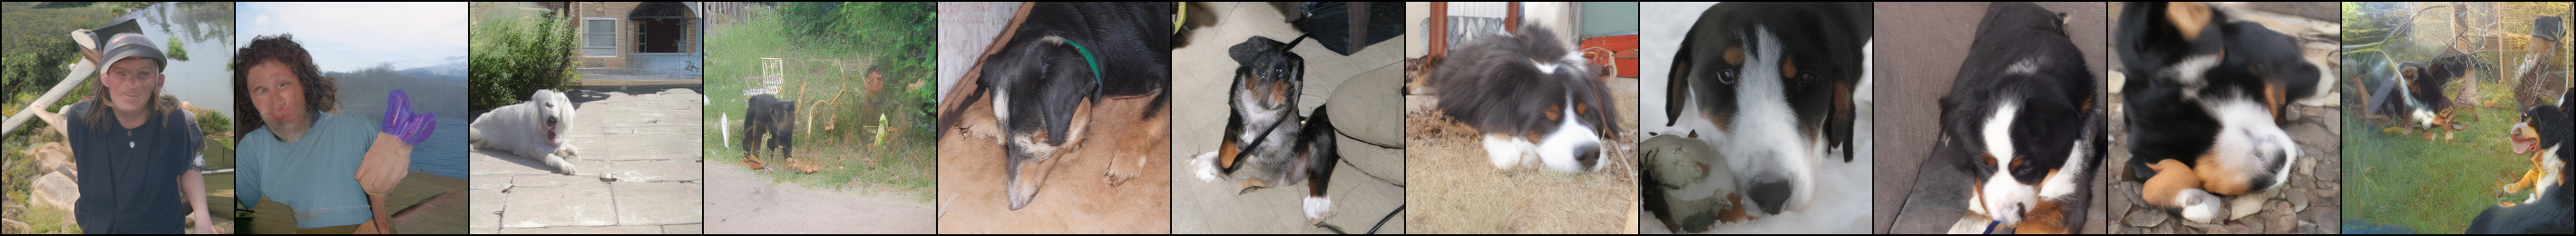

In [30]:
import numpy as np 
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid


classes = [238]   # define classes to be sampled here
n_samples_per_class = 11

ddim_steps = 20
ddim_eta = 0.0
scale = 3.0   # for unconditional guidance


all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        uc = model.get_learned_conditioning(
            {model.cond_stage_key: torch.tensor(n_samples_per_class*[1000]).to(model.device)}
            )
        
        for class_label in classes:
            print(f"rendering {n_samples_per_class} examples of class '{class_label}' in {ddim_steps} steps and using s={scale:.2f}.")
            xc = torch.tensor(n_samples_per_class*[class_label])
            xc[-1] = 239
            c = model.get_learned_conditioning({model.cond_stage_key: xc.to(model.device)})

            a = torch.linspace(0,1,11)
            b = 1-a
            cc = torch.zeros(11,1,512).cuda()
            for i in range(a.shape[0]):
              cc[i] = a[i]*c[0]+(1-b[i])*c[-1]
            
            samples_ddim, _ = sampler.sample(S=ddim_steps,
                                             conditioning=cc,
                                             batch_size=n_samples_per_class,
                                             shape=[3, 64, 64],
                                             verbose=False,
                                             unconditional_guidance_scale=scale,
                                             unconditional_conditioning=None, 
                                             eta=ddim_eta)

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
                                         min=0.0, max=1.0)
            all_samples.append(x_samples_ddim)


# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

In [29]:
c.shape

torch.Size([11, 1, 512])